# GRAPE on a qubit with an uncertain frequency

Lets start with the example of GRAPE on a qubit, optimizing the drive envelope to be robust to variations in qubit frequency. This example will illustrate the utility of batching, allowing us to average over many different qubit frequencies to obtain a pulse that achieves a high-fidelity gate and is robust to frequency fluctuations.

This example is available as a Jupyter notebook [here](https://github.com/dkweiss31/qontrol/blob/main/docs/examples/qubit.ipynb).

In [1]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from jax import Array
from jax.random import PRNGKey, normal

import qontrol as qtrl

In [2]:
time = 30
control_dt = 2.0
ntimes = int(time // control_dt) + 1
optimizer = optax.adam(learning_rate=0.0001, b1=0.99, b2=0.99)
tsave = jnp.linspace(0, time, ntimes)
options = qtrl.GRAPEOptions(
    verbose=False, save_states=False, progress_meter=None, epochs=4000
)

Here we initialize the random qubit frequency fluctuations pulled from a normal distribution. Note that the drive is on resonance with the average value of the qubit frequency.

In [3]:
key = PRNGKey(42)
random_freqs = 2.0 * jnp.pi * normal(key, shape=(21,)) / 500
H0 = random_freqs[:, None, None] * dq.sigmaz()[None]
H1s = [dq.sigmax(), dq.sigmay()]
H1_labels = ['X', 'Y']

Here we define what final states the initial states should map to. In this case we want to achieve a Y gate

In [4]:
initial_states = [dq.basis(2, 0), dq.basis(2, 1)]
target_states = [-1j * dq.basis(2, 1), 1j * dq.basis(2, 0)]

We next initialize our first guess for the controls and define the function that, given the controls, returns the Hamiltonian. To allow for various different ways of passing in controls as well as doing time-optimal control, we also require an update_function that specifies how to update the Hamiltonian `H` and control times `tsave`.

In [5]:
init_drive_params = -0.001 * jnp.ones((len(H1s), ntimes - 1))


def H_pwc(values: Array) -> dq.TimeArray:
    H = H0
    for idx, _H1 in enumerate(H1s):
        H += dq.pwc(tsave, values[idx], _H1)
    return H


def update_function(H: dq.TimeArray, drive_params: Array) -> tuple[dq.TimeArray, Array]:
    return H(drive_params), tsave


ham_time_update = qtrl.hamiltonian_time_updater(H_pwc, update_function)

In this example we use the coherent definition of the infidelity and penalize drive strengths above 16 MHz

In [6]:
costs = [
    qtrl.coherent_infidelity(target_states=target_states, cost_multiplier=1.0),
    qtrl.control_norm(2.0 * jnp.pi * 0.016, cost_multiplier=1.0),
]

In [7]:
opt_params = qtrl.grape(
    ham_time_update,
    initial_states=initial_states,
    costs=costs,
    params_to_optimize=init_drive_params,
    optimizer=optimizer,
    options=options,
)

target fidelity reached
fids: [0.9995012]


Let's plot the pulse

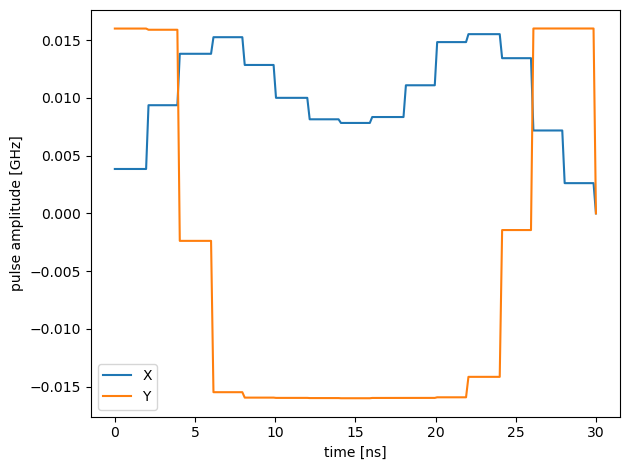

In [8]:
# plot the pulse
finer_times = jnp.linspace(0.0, time, 201)
opt_H1s = [
    dq.pwc(tsave, opt_params[drive_idx] / (2.0 * jnp.pi), _H1)
    for drive_idx, _H1 in enumerate(H1s)
]
prefactors = [
    [opt_H1s[drive_idx].prefactor(t) for t in finer_times]
    for drive_idx in range(len(H1s))
]
fig, ax = plt.subplots()
for drive_idx in range(len(H1s)):
    plt.plot(finer_times, np.real(prefactors[drive_idx]), label=H1_labels[drive_idx])
ax.set_xlabel('time [ns]')
ax.set_ylabel('pulse amplitude [GHz]')
ax.legend()
plt.tight_layout()
plt.show()

We see that despite the MHz-level frequency variations of the qubit frequency, the obtained pulse succesfully performs the desired state transfer! Here we plot the population in the $|1\rangle$ state when beginning in the $|0\rangle$ state for the different batch instances

|██████████| 100.0% ◆ elapsed 4.34ms ◆ remaining 0.00ms


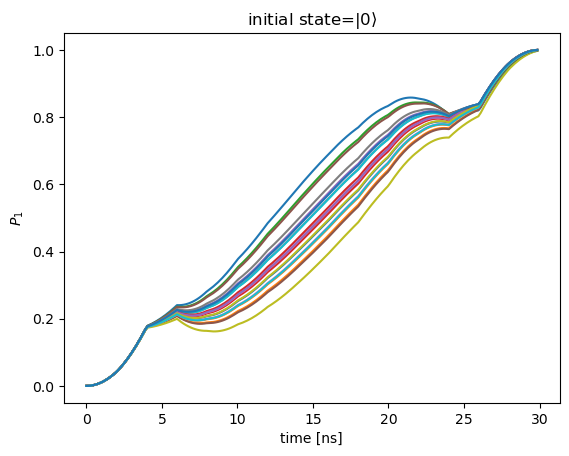

In [9]:
H = H_pwc(opt_params)
plot_result = dq.sesolve(
    H,
    initial_states,
    finer_times,
    exp_ops=[dq.basis(2, idx) @ dq.dag(dq.basis(2, idx)) for idx in range(2)],
)
init_labels = [r'$|0\rangle$', r'$|1\rangle$']
exp_labels = [r'$|0\rangle$', r'$|1\rangle$']

# for brevity only plot one initial state
state_idx_to_plot = 0
fig, ax = plt.subplots()
expects = plot_result.expects[:, state_idx_to_plot, 1]
for e_result in expects:
    plt.plot(finer_times, np.real(e_result))
ax.set_xlabel('time [ns]')
ax.set_ylabel('$P_1$')
ax.set_title(f'initial state={init_labels[state_idx_to_plot]}')
plt.show()